In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd


In [12]:
# Load the scores file
scrs = pd.read_csv('scores/scores_1617209354.csv', delimiter=',')
print(scrs)

    tp    tn    fp   fn  precision    recall   f_score  epoch  batch
0   85  1737  2159   51   0.037879  0.625000  0.071429      1      0
1   63  2192  1692   85   0.035897  0.425676  0.066211      1     10
2   49  2454  1438   91   0.032952  0.350000  0.060234      1     20
3   38  2763  1140   91   0.032258  0.294574  0.058148      1     30
4   26  3068   839   99   0.030058  0.208000  0.052525      1     40
..  ..   ...   ...  ...        ...       ...       ...    ...    ...
81   9  3895     8  120   0.529412  0.069767  0.123288      2    379
82  11  3893     6  122   0.647059  0.082707  0.146667      2    389
83  11  3889     9  123   0.550000  0.082090  0.142857      2    399
84  15  3902     9  106   0.625000  0.123967  0.206897      2    409
85  11  3884     9  128   0.550000  0.079137  0.138365      2    419

[86 rows x 9 columns]


In [18]:
# Add cumulative scores
cols = ['tp', 'tn', 'fp', 'fn']
for col in cols:
    n_col = 'sum_' + col
    scrs[n_col] = scrs[col].cumsum()
scrs['sum_precision'] = (scrs['sum_tp'] / (scrs['sum_tp'] + scrs['sum_fp'] + 1e-12))
scrs['sum_recall'] = (scrs['sum_tp'] / (scrs['sum_tp'] + scrs['sum_fn'] + 1e-12))
scrs['sum_f_score'] = (2 * scrs['sum_precision'] * scrs['sum_recall'])/( scrs['sum_precision'] + scrs['sum_recall'])

No handles with labels found to put in legend.


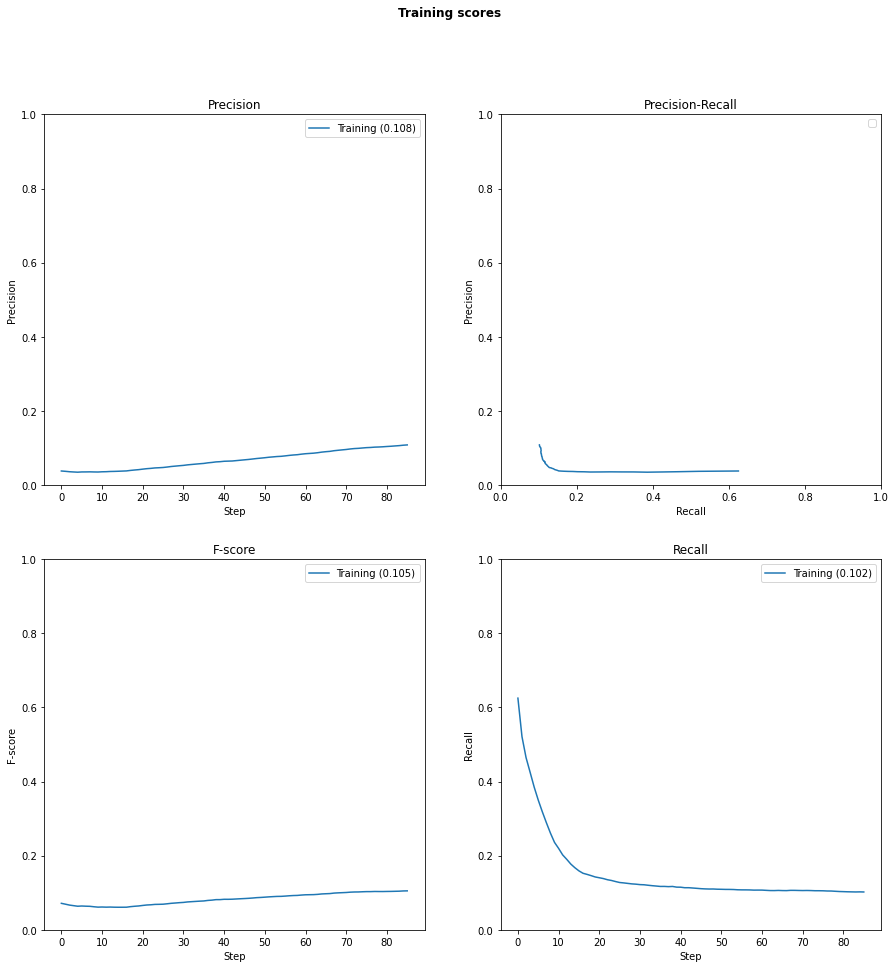

In [20]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['savefig.facecolor'] = 'white'
fig, ((pre_ax, p_r_ax), (fsc_ax, rec_ax)) = plt.subplots(2, 2)
fig.suptitle('Training scores',fontweight = "bold")
pre_ax.title.set_text('Precision')
pre_ax.set_ylim(0.0, 1.0)
pre_ax.plot(scrs.sum_precision, label = f'Training ({round(scrs.sum_precision.iloc[-1], 3)})')
pre_ax.set_xticks(list(scrs.index)[0::10])
pre_ax.set_xticklabels(list(scrs.index)[0::10])
pre_ax.set_xlabel('Step')
pre_ax.set_ylabel('Precision')
pre_ax.legend()
p_r_ax.title.set_text('Precision-Recall')
p_r_ax.set_xlim(0.0, 1.0)
p_r_ax.set_ylim(0.0, 1.0)
p_r_ax.plot(scrs.sum_recall, scrs.sum_precision)
p_r_ax.set_xlabel('Recall')
p_r_ax.set_ylabel('Precision')
p_r_ax.legend()
rec_ax.title.set_text('Recall')
rec_ax.set_ylim(0.0, 1.0)
rec_ax.plot(scrs.sum_recall, label = f'Training ({round(scrs.sum_recall.iloc[-1], 3)})')
rec_ax.set_xticks(list(scrs.index)[0::10])
rec_ax.set_xticklabels(list(scrs.index)[0::10])
rec_ax.set_xlabel('Step')
rec_ax.set_ylabel('Recall')
rec_ax.legend()
fsc_ax.title.set_text('F-score')
fsc_ax.set_ylim(0.0, 1.0)
fsc_ax.plot(scrs.sum_f_score, label = f'Training ({round(scrs.sum_f_score.iloc[-1], 3)})')
fsc_ax.set_xticks(list(scrs.index)[0::10])
fsc_ax.set_xticklabels(list(scrs.index)[0::10])
fsc_ax.set_xlabel('Step')
fsc_ax.set_ylabel('F-score')
fsc_ax.legend()
fig.savefig('scores/scores')